In [0]:
 from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import pandas as pd
from torch.autograd import Variable
from torchvision.models import resnet152
from google.colab.patches import cv2_imshow
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from math import sqrt


import sys

import itertools

from torch.utils.data import DataLoader
from torch.autograd import Variable
import argparse
import time
import datetime
from torch.utils.data import TensorDataset, DataLoader


In [0]:

##############################
#         MergeLayer
##############################

class MergeLayer(nn.Module):    
    def __init__(self, inputsize):
        super(Metadata, self).__init__()
        self.fc1 = nn.Linear(inputsize, 1024)
        self.out = nn.Linear(1024, 1)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.6)
       

     
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.drop(x)
        x = self.out(x)
       
            
        
        return x



##############################
#         Encoder
##############################


class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        resnet = resnet152(pretrained=True)
        
        self.final = nn.Sequential(
            nn.Linear(resnet.fc.in_features, latent_dim), nn.BatchNorm1d(latent_dim, momentum=0.01)
        )

    def forward(self, x):
        
        return self.final(x)   # To be trained layer on the pretrain model


##############################
#           LSTM
##############################


class LSTM(nn.Module):
    def __init__(self, latent_dim, num_layers, hidden_dim, bidirectional):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(latent_dim, hidden_dim, num_layers, batch_first=True, bidirectional=bidirectional)
        self.hidden_state = None

    def reset_hidden_state(self):
        self.hidden_state = None

    def forward(self, x):
        x, self.hidden_state = self.lstm(x, self.hidden_state)
        return x




##############################
#         ConvLSTM
##############################


class ConvLSTM(nn.Module):
    def __init__(
        self,metasize, num_classes, latent_dim=512, lstm_layers=1, hidden_dim=1024, bidirectional=True):
        super(ConvLSTM, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.lstm = LSTM(latent_dim, lstm_layers, hidden_dim, bidirectional)
        self.output_layers = nn.Sequential(
            nn.Linear(2 * hidden_dim if bidirectional else hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim, momentum=0.01),
            nn.ReLU(),
            nn.Dropout(0.8),
            nn.Linear(hidden_dim, num_classes),
            
        )
        self.dropout = nn.Dropout(0.2)
        self.mergelayer = MergeLayer(512 + num_classes)
        
     
        self.fc1 = nn.Linear(metasize, 512)
        
        self.batchnorm = nn.BatchNorm1d(512 + num_classes, momentum=0.01)
        self.batchnorm1 = nn.BatchNorm1d(num_classes, momentum=0.01)
        
       
        self.relu = nn.ReLU()

    def forward(self, x,metadata):
        batch_size, seq_length, e = x.shape
        x = x.view(batch_size * seq_length, e)
        x = self.encoder(x)
        x = x.view(batch_size, seq_length, -1)
        x = self.lstm(x)

        x = x[:, -1]
        x = self.relu(self.batchnorm1(self.output_layers(x)))

        # Output of LSTM
        
        metadata = self.relu(self.fc1(metadata))
        metadata = self.dropout(metadata)

        # Output of Metadata
        

        flattened_layer = torch.cat((x, metadata), 1) # Merging two outputs
        

        # Merge Layer
        mix =  self.mergelayer(self.relu(flattened_layer))        

            
        return mix

In [0]:
metadata = pd.read_csv('gdrive/My Drive/Project - Box Office Prediction/Dataset/Metadata/final_data.csv', sep=',') # Loading Data

In [0]:
metadata.head()

,budget,original_language,popularity,runtime,collection_name,has_collection,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Crime,genre_Romance,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Mystery,genre_Family,genre_Fantasy,genre_History,genre_War,genre_Animation,num_companies,production_company_Warner Bros.,production_company_Universal Pictures,production_company_Twentieth Century Fox Film Corporation,production_company_Paramount Pictures,production_company_Columbia Pictures,production_company_New Line Cinema,production_company_Metro-Goldwyn-Mayer (MGM),production_company_Columbia Pictures Corporation,production_company_Relativity Media,production_company_Touchstone Pictures,production_company_Village Roadshow Pictures,production_company_Miramax Films,production_company_United Artists,production_company_Walt Disney Pictures,production_company_TriStar Pictures,production_company_Canal+,...,departments_Actors,log_budget,has_homepage,release_date_year,release_date_weekday,release_date_month,release_date_weekofyear,release_date_day,release_date_quarter,len_title,words_title,len_tagline,words_tagline,len_overview,words_overview,len_original_title,words_original_title,title_oof,tagline_oof,overview_oof,original_title_oof,budget_to_popularity,budget_to_runtime,_budget_year_ratio,_releaseYear_popularity_ratio,_releaseYear_popularity_ratio2,runtime_to_mean_year,popularity_to_mean_year,budget_to_mean_year,budget_to_year,budget_to_mean_year_to_year,popularity_to_mean_year_to_log_budget,year_to_log_budget,budget_to_runtime_to_year,genders_1_cast_to_log_budget,all_genres_to_popularity_to_mean_year,genders_2_crew_to_budget_to_mean_year,overview_oof_to_genders_2_crew,videoname,revenue
0,14000000,9,6.575393,93.0,245,1,1,434,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,...,0,16.454568,0,2015,4,2,8,20,1,22,38,52,86,155,243,22,38,16.750935,16.923428,16.882853,17.036189,2.129150e+06,150537.634409,3.448085,306.445562,0.003263,0.822766,0.681495,0.628829,6947.890819,0.000312,0.041417,122.458396,74.708503,0.486187,636.835555,20.673352,1.298681,0,12314651
1,40000000,9,8.248895,113.0,572,1,4,465,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,17.504390,0,2004,4,8,32,6,3,40,59,60,100,393,601,40,59,16.864185,16.293762,16.769947,16.894523,4.849134e+06,353982.300885,9.960120,242.941630,0.004116,1.075981,0.947672,1.227688,19960.079840,0.000613,0.054139,114.485566,176.637875,0.571285,490.676160,3.258157,4.192487,1,95149435
2,3300000,9,64.299990,105.0,1,0,1,590,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,15.009433,1,2014,4,10,41,10,4,8,12,47,78,130,194,8,12,16.645945,16.607314,16.584059,16.615304,5.132194e+04,31428.571429,0.813570,31.321933,0.031927,0.973533,6.283763,0.139919,1638.530288,0.000069,0.418654,134.182281,15.605050,0.466373,93.892778,78.617108,1.507642,2,13092000
3,1200000,15,3.174936,122.0,1,0,2,670,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,13.997833,1,2012,4,3,10,9,1,7,11,0,4,581,900,7,11,16.656919,16.449349,16.673331,16.644843,3.779604e+05,9836.065574,0.296432,633.713561,0.001578,1.147571,0.377972,0.055772,596.421471,0.000028,0.027002,143.736535,4.888701,0.071440,1772.619541,0.000000,0.000000,3,16000000
4,8000000,9,0.743274,83.0,1,0,3,289,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,15.894952,0,1987,3,8,32,6,3,38,60,0,4,150,235,38,60,16.681575,16.464867,16.685295,16.670305,1.076319e+07,96385.542169,2.026256,2673.307555,0.000374,0.759378,0.094232,0.473373,4026.170106,0.000238,0.005928,125.008240,48.508074,0.000000,3066.909725,8.450000,4.171324,5,3261638


In [0]:

videonames = metadata['videoname'].values 

metadata = metadata.drop('videoname',axis=1)
# metadata = metadata.dropna()

metadata.head()
xSize, ySize = 224, 224
channels = 3

Y = metadata['revenue']
metadata = metadata.drop(columns=['revenue'])

In [0]:
# Identifying the all numeric columns excluding one hot encoding onces

datacolumns = metadata.columns
numericColumn = []
for i in range(0,len(datacolumns)):
  if(np.max(metadata[datacolumns[i]]) > 1):
    numericColumn.append(i)


In [0]:
MX_train, MX_test, train_Y, test_Y = train_test_split(metadata.reset_index(drop=True), Y, test_size=0.2) # Split train and test

In [0]:
# Loading the Embeding from the folder
tensorArray = []
for i in videonames:
   
    video = torch.load("gdrive/My Drive/Project - Box Office Prediction/EmbedingLSTM/"+ str(i) +"-Embedings.pt")
    tensorArray.append(video.cpu().numpy())
    

In [0]:
tensor = torch.FloatTensor(tensorArray)

In [0]:
tensor.shape # size of tensor

torch.Size([1489, 100, 2048])

In [0]:
trainindex = MX_train.index.tolist()
testindex = MX_test.index.tolist()


In [0]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 



train_X = tensor[MX_train.index.tolist(),:,:] # Spliting the tensor with the respect to train split

test_X = tensor[MX_test.index.tolist(),:,:] # Spliting the tensor with the respect to test split

testindex = np.array(MX_test.index.tolist())
trainindex = np.array(MX_train.index.tolist())

MX_train = MX_train.values
MX_test = MX_test.values
train_Y = train_Y.values
test_Y = test_Y.values

scaler_X = MinMaxScaler()  # Scaling the numeric values excluding one hot encoding columns
MX_train[:,numericColumn] = scaler_X.fit_transform(MX_train[:,numericColumn])
MX_test[:,numericColumn] = scaler_X.transform(MX_test[:,numericColumn])

 
scaler_Y = MinMaxScaler()
train_Y = scaler_Y.fit_transform(train_Y.reshape(-1,1))
test_Y = scaler_Y.transform(test_Y.reshape(-1,1))


# Creating data loader
train_data = TensorDataset(train_X,torch.FloatTensor(MX_train), torch.FloatTensor(train_Y),torch.IntTensor(trainindex))
test_data = TensorDataset(test_X,torch.FloatTensor(MX_test), torch.FloatTensor(test_Y),torch.IntTensor(testindex))
batch_size = 30

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last=False)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size,drop_last=False)


In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) 


In [ ]:
import pdb
latent_dim = 512
num_epochs = 3000
lowest = 10000
lowtestp = []
lowtestg = []
lowtrainp = []
lowtraing = []
lowtestindex = []
lowtrainindex = []
# Classification criterion
criterion = torch.nn.MSELoss().to(device)

# Define network
model = ConvLSTM(
    metasize = metadata.shape[1],
    num_classes=30,
    latent_dim=latent_dim,
    lstm_layers=1,
    hidden_dim=512,
    bidirectional=False,
    
)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)



def test_model(epoch):
    """ Evaluate the model on the test set """
    print("")
    model.eval()
    test_metrics = {"loss": [],"RMSE": [],"R2" : []}
     
    testp = []
    testg = []
    testi = []
    for batch_i, (X,MX, y,indexs) in enumerate(test_loader):

        MetaX = Variable(MX.to(device), requires_grad=False)
        image_sequences = Variable(X.to(device), requires_grad=False)
        labels = Variable(y, requires_grad=False).to(device)
        with torch.no_grad():
            # Reset LSTM hidden state
            model.lstm.reset_hidden_state()
            # Get sequence predictions
            predictions = model(image_sequences,MetaX)
        # Compute metrics
        testp.extend(predictions.tolist())
        testg.extend(labels.tolist())
        testi.extend(indexs)
        loss = criterion(predictions, labels).item()
        r2 = r2_score(labels.detach().cpu().numpy(), predictions.detach().cpu().numpy())  
        rmse = sqrt(loss)
        # Keep track of loss and accuracy
        test_metrics["loss"].append(loss)
        test_metrics["RMSE"].append(rmse)
        test_metrics["R2"].append(r2)
      
        # Log test performance
        sys.stdout.write(
            "\rTesting -- [Batch %d/%d] [Loss: %f (%f)] [r2: (%f)] [rmse: (%f)]"
            % (
                batch_i,
                len(test_loader),
                loss,
                np.mean(test_metrics["loss"]),
               np.mean(test_metrics["R2"]),
               np.mean(test_metrics["RMSE"])
                
               
            )
        )
    model.train()
    print("")
    return  np.mean(test_metrics["loss"]),testp,testg,testi
    
model.train()
trainLoss = []
testLoss = []
for epoch in range(num_epochs):
    epoch_metrics = {"loss": [],"RMSE": [],"R2" : []}
    prev_time = time.time()
    print(f"--- Epoch {epoch} ---")
    trainp = []
    traing = []
    testp = []
    testg = []
    testi = []
    traini = []
    for batch_i, (X,MX, y,index) in enumerate(train_loader):
        
        if X.size(0) == 1:
            continue

        
        # pdb.set_trace()
        
        MetaX = Variable(MX.to(device), requires_grad=True)
        image_sequences = Variable(X.to(device), requires_grad=True)
        labels = Variable(y.to(device), requires_grad=False)

        optimizer.zero_grad()

        # Reset LSTM hidden state
        model.lstm.reset_hidden_state()

        # Get sequence predictions
        predictions = model(image_sequences,MetaX)

        # Compute metrics
        trainp.extend(predictions.tolist())
        traing.extend(labels.tolist())
        traini.extend(index)
        loss = criterion(predictions, labels)

        
      
      

        loss.backward()
        optimizer.step()
        r2 = r2_score(labels.detach().cpu().numpy(), predictions.detach().cpu().numpy())
        rmse = sqrt(loss.item())
        # Keep track of epoch metrics
        epoch_metrics["loss"].append(loss.item())
        epoch_metrics["RMSE"].append(rmse)
        epoch_metrics["R2"].append(r2)
       
        # Determine approximate time left
        batches_done = epoch * len(train_loader) + batch_i
        batches_left = num_epochs * len(train_loader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()

        # Print log
        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f)]  [r2: (%f)] [rmse: (%f)], ETA: %s"
            % (
                epoch,
                num_epochs,
                batch_i,
                len(train_loader),
                loss.item(),
                np.mean(epoch_metrics["loss"]),
                np.mean(epoch_metrics["R2"]),
                np.mean(epoch_metrics["RMSE"]),
                time_left,
            )
        )

        # Empty cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    trainLoss.append(np.mean(epoch_metrics["loss"]))
    # Evaluate the model on the test set
    testL,testp,testg,testi = test_model(epoch)
    if(lowest > testL):
        lowest = testL
        if(epoch > 1000):

          print("Train R2 = ",r2_score(traing, trainp))
          print("Test R2 = ",r2_score(testg, testp))
          lowtestp = testp
          lowtestg = testg
          lowtrainp = trainp
          lowtraing = traing
          lowtestindex = testi
          lowtrainindex = traini
          fig, axs = plt.subplots(1, 1, figsize=(10, 10))
          fig.suptitle("Training Loss")
          axs.plot(trainLoss, label="Train data")
          axs.plot(trainLoss, "o")
          axs.set_ylabel('MSE Loss')
          axs.set_xlabel('Epochs')
          plt.legend()
          plt.show()

          fig, axs = plt.subplots(1, 1, figsize=(10, 10))
          fig.suptitle("Testing Loss")
          axs.plot(testLoss , label="Test data")
          axs.plot(testLoss, "x")
          axs.set_ylabel('MSE Loss')
          axs.set_xlabel('Epochs')
          plt.legend()
          plt.show()



          fig, axs = plt.subplots(1, 1, figsize=(10, 10))
          fig.suptitle("Loss")
          axs.plot(trainLoss,label="Train data")
          axs.plot(testLoss,label="Test data")
          axs.set_ylabel('MSE Loss')
          axs.set_xlabel('Epochs')
          plt.legend()
          plt.show()

          


          Y_t = scaler_Y.inverse_transform(testg)
          p_t = scaler_Y.inverse_transform(testp)
          Y_tr = scaler_Y.inverse_transform(traing)
          p_tr = scaler_Y.inverse_transform(trainp)

          print('MAPE : ',mean_absolute_percentage_error(Y_t,p_t))


          plt.figure(figsize=(15,10))
          plt.subplot(1, 2, 1)
          plt.xlabel("Movie")
          plt.ylabel("Revenue")
          # plt.title("Movie vs Revenue on training data (Epoch: "+str(i)+", Loss: "+str(round(testLoss, 3))+")")
          plt.plot(p_tr, "o", label="Prediction")
          plt.plot(Y_tr, "*", label="Ground Truth")
          plt.legend()

          plt.subplot(1, 2, 2)

          plt.xlabel("Movie")
          plt.ylabel("Revenue")
          # plt.title("Movie vs Revenue on training data (Epoch: "+str(i)+", Loss: "+str(round(testLoss, 3))+")")
          plt.plot(p_t, "o", label="Prediction")
          plt.plot(Y_t, "*", label="Ground Truth")
          plt.legend()
          plt.show()

          plt.figure(figsize=(20,10))

          plt.xlabel("Movie")
          plt.ylabel("Revenue")
          plt.title("Movie vs Revenue on training data (Epoch: "+str(epoch)+", Loss: "+str(round(np.mean(epoch_metrics["loss"]), 3))+")")
          plt.plot(p_tr, "o", label="Prediction")
          plt.plot(Y_tr, "*", label="Ground Truth")
          plt.legend()


    testLoss.append(testL)


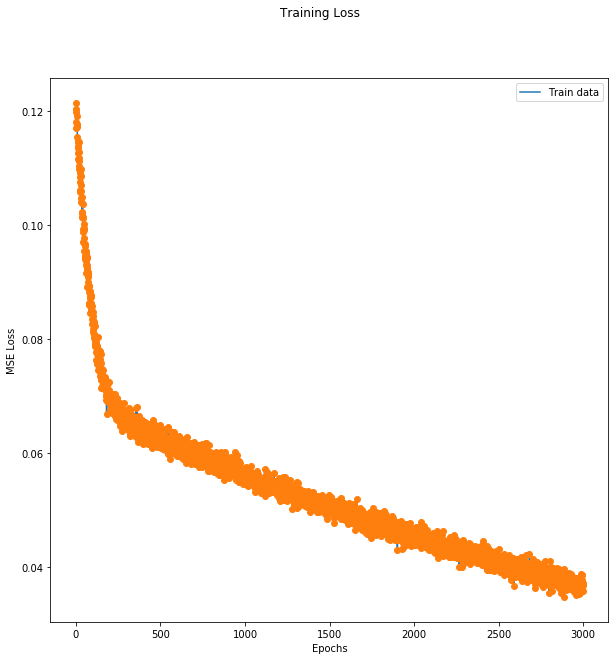

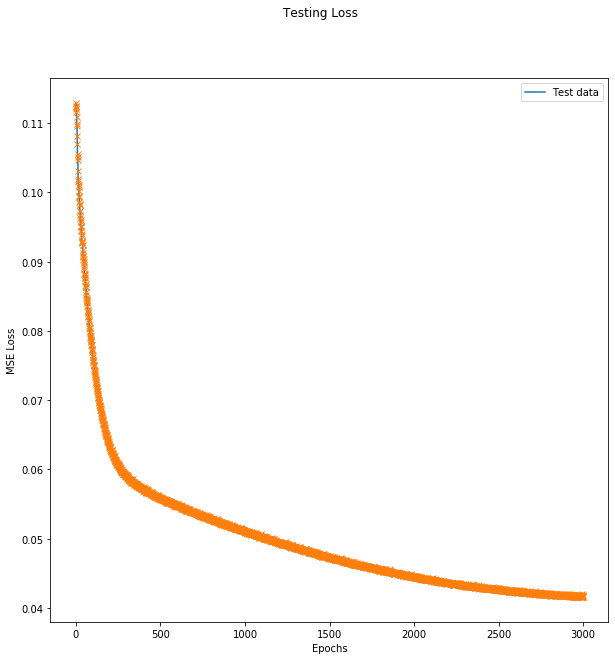

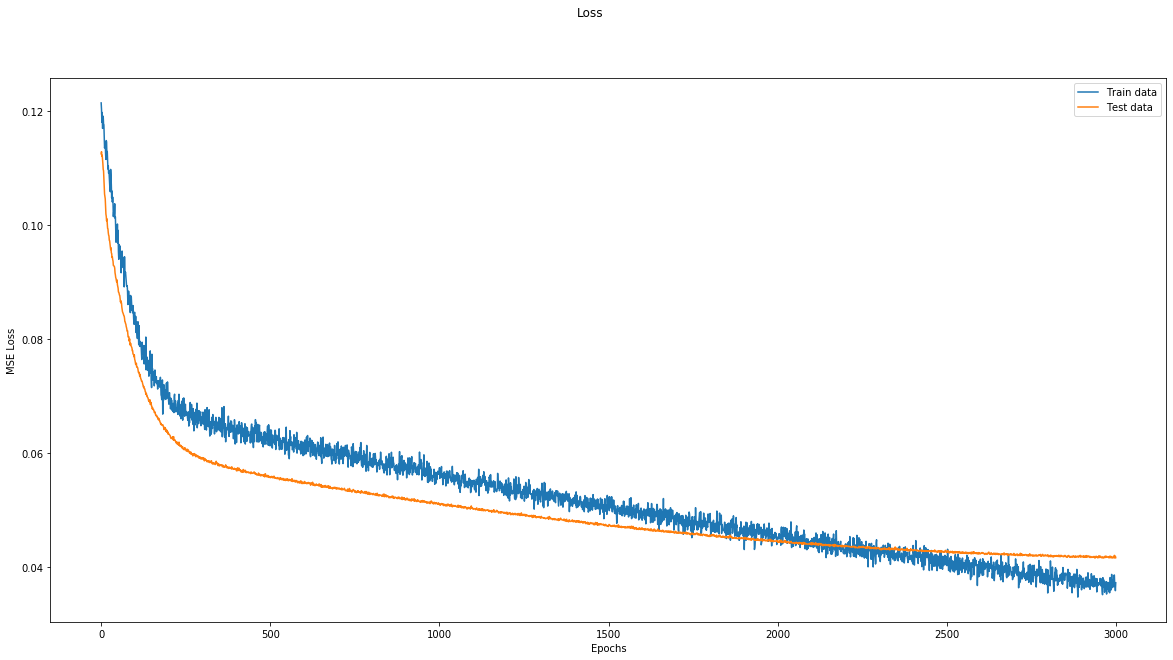

In [0]:

fig, axs = plt.subplots(1, 1, figsize=(10, 10))
fig.suptitle("Training Loss")
axs.plot(trainLoss, label="Train data")
axs.plot(trainLoss, "o")
axs.set_ylabel('MSE Loss')
axs.set_xlabel('Epochs')
plt.legend()
plt.show()

fig, axs = plt.subplots(1, 1, figsize=(10, 10))
fig.suptitle("Testing Loss")
axs.plot(testLoss , label="Test data")
axs.plot(testLoss, "x")
axs.set_ylabel('MSE Loss')
axs.set_xlabel('Epochs')
plt.legend()
plt.show()

fig, axs = plt.subplots(1, 1, figsize=(20, 10))
fig.suptitle("Loss")
axs.plot(trainLoss,label="Train data")
axs.plot(testLoss,label="Test data")
axs.set_ylabel('MSE Loss')
axs.set_xlabel('Epochs')
plt.legend()
plt.show()